In [1]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro
import torch
import VAE
import ConvEncoderDecoder as CED
import LinearEncoderDecoder as LED

from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [10]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [11]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [79]:
USE_CUDA = False
NUM_EPOCHS = 20
TEST_FREQUENCY = 5
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

model = VAE.VAE(LED.LinearEncoder(2, 400, 100), LED.LinearDecoder(2, 400, 100))
#model = VAE.VAE(CED.ConvEncoder(2, 16), CED.ConvDecoder(2, 16))

optimizer = pyro.optim.Adam({'lr': 0.001})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 203.3777
[epoch 000] average test loss: 173.2468
[epoch 001]  average training loss: 169.9729
[epoch 002]  average training loss: 166.5053
[epoch 003]  average training loss: 165.0102
[epoch 004]  average training loss: 164.1534
[epoch 005]  average training loss: 163.6618
[epoch 005] average test loss: 163.8773
[epoch 006]  average training loss: 163.3531
[epoch 007]  average training loss: 163.1672
[epoch 008]  average training loss: 163.0712
[epoch 009]  average training loss: 162.9961
[epoch 010]  average training loss: 162.9583
[epoch 010] average test loss: 163.3825
[epoch 011]  average training loss: 162.9502
[epoch 012]  average training loss: 162.9294
[epoch 013]  average training loss: 162.9159
[epoch 014]  average training loss: 162.9179
[epoch 015]  average training loss: 162.9195
[epoch 015] average test loss: 163.3784
[epoch 016]  average training loss: 162.9143
[epoch 017]  average training loss: 162.9224


KeyboardInterrupt: 

In [3]:
from TrainedVAE import TrainedLinearVAE

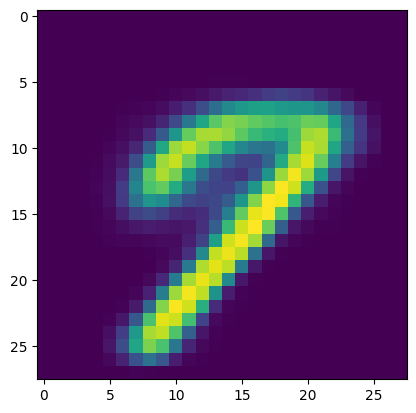

In [7]:
s = TrainedLinearVAE.decoder(torch.randn(1, 2)).detach().numpy().reshape(28, 28)

plt.imshow(s)
plt.show()

In [16]:
train_loader, test_loader = setup_data_loaders(batch_size=20000, use_cuda=False)


<AxesSubplot: >

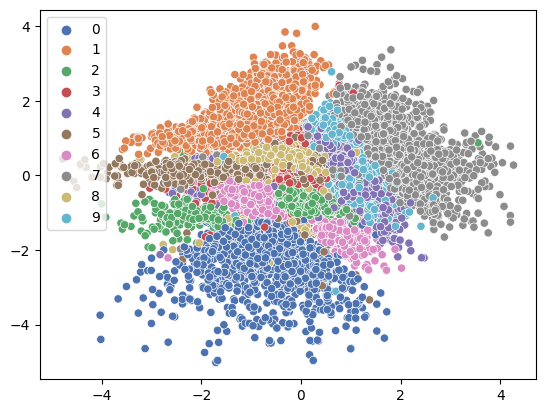

In [17]:
import seaborn as sns
inputs, classes = next(iter(train_loader)) 
z_mean, z_scale = TrainedLinearVAE.encoder(inputs)
c = classes.numpy()
z = z_mean.detach().numpy()
sns.scatterplot(x=z[:,0],y=z[:,1], hue=c, palette="deep")